In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from typing import Tuple

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc
from sklearn.pipeline import Pipeline, make_pipeline


In [201]:
df = pd.read_csv("../../../Module 2/feature_frame.csv")

In [202]:
df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [204]:
info_cols = ["variant_id", "order_id", "user_id", "created_at", "order_date"]
label_col = "outcome"
features_cols = [col for col in df.columns if col not in info_cols + [label_col]]

categorical_cols = ["product_type", "vendor"]
binary_cols = ["ordered_before", "abandoned_before", "active_snoozed", "set_as_regular"]
numerical_cols = [col for col in features_cols if col not in categorical_cols + binary_cols]

In [205]:
order_size = df.groupby("order_id").outcome.sum().reset_index()
big_orders = order_size.loc[order_size["outcome"] >= 5, "order_id"]
df_selected = df.loc[lambda x: x.order_id.isin(big_orders)]
df_selected

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880541,33826439594116,healthcarevitamins,3643241300100,3864791220356,2021-03-03 12:56:04,2021-03-03 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880544,33826439594116,healthcarevitamins,3643254800516,3893722808452,2021-03-03 13:19:28,2021-03-03 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880545,33826439594116,healthcarevitamins,3643274788996,3883757174916,2021-03-03 13:57:35,2021-03-03 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880546,33826439594116,healthcarevitamins,3643283734660,3874925314180,2021-03-03 14:14:24,2021-03-03 00:00:00,7,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392


In [206]:
df_selected['order_date'] = pd.to_datetime(df_selected['order_date'])
df_selected['created_at'] = pd.to_datetime(df_selected['created_at'])
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2163953 entries, 0 to 2880547
Data columns (total 27 columns):
 #   Column                            Dtype         
---  ------                            -----         
 0   variant_id                        int64         
 1   product_type                      object        
 2   order_id                          int64         
 3   user_id                           int64         
 4   created_at                        datetime64[ns]
 5   order_date                        datetime64[ns]
 6   user_order_seq                    int64         
 7   outcome                           float64       
 8   ordered_before                    float64       
 9   abandoned_before                  float64       
 10  active_snoozed                    float64       
 11  set_as_regular                    float64       
 12  normalised_price                  float64       
 13  discount_pct                      float64       
 14  vendor                 

/var/folders/89/kh4sf6hs6xngc9mwq6wfcb_r0000gn/T/ipykernel_55548/2768600364.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['order_date'] = pd.to_datetime(df_selected['order_date'])
/var/folders/89/kh4sf6hs6xngc9mwq6wfcb_r0000gn/T/ipykernel_55548/2768600364.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['created_at'] = pd.to_datetime(df_selected['created_at'])


In [207]:
df.order_id.nunique() > df_selected.order_id.nunique()

True

In [208]:
daily_orders = df_selected.groupby('order_date').order_id.nunique()
daily_orders.head()

order_date
2020-10-05     3
2020-10-06     7
2020-10-07     6
2020-10-08    12
2020-10-09     4
Name: order_id, dtype: int64

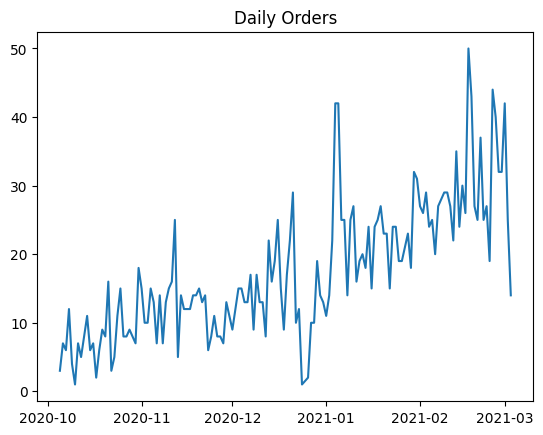

In [209]:
plt.plot(daily_orders, label="daily orders")
plt.title("Daily Orders");

To avoid information leakage, like having the same orders in train/test, we make a temporal split. Also, due to the strong temporal component, it makes sense to split data in a chronological way and not randomly.

In [210]:
cumsum_daily_orders = daily_orders.cumsum() / daily_orders.sum()
cumsum_daily_orders = cumsum_daily_orders.reset_index()

train_val_cutoff = cumsum_daily_orders.loc[cumsum_daily_orders["order_id"] <= 0.7, "order_date"].max()
val_test_cutoff = cumsum_daily_orders.loc[(cumsum_daily_orders["order_id"] <= 0.9), "order_date"].max()

print("Train since: ", cumsum_daily_orders.order_date.min())
print("Train until: ", train_val_cutoff)
print("Val until: ", val_test_cutoff)
print("Test until: ", cumsum_daily_orders.order_date.max())

Train since:  2020-10-05 00:00:00
Train until:  2021-02-04 00:00:00
Val until:  2021-02-22 00:00:00
Test until:  2021-03-03 00:00:00


In [211]:
train_df = df_selected[df_selected.order_date <= train_val_cutoff]
val_df = df_selected[(df_selected.order_date > train_val_cutoff) & (df_selected.order_date <= val_test_cutoff)]
test_df = df_selected[df_selected.order_date > val_test_cutoff]

### Custom functions

In [255]:
def plot_roc_and_pr_curves(model_name: str, y_test: pd.Series, y_pred: pd.Series, threshold_target: float=None, figure:Tuple[matplotlib.figure.Figure, np.array]=None):
    """
    Plots ROC and Precision-Recall curves side-by-side with AUC as legend.

    Args:
        model_name (str): The name of the classification model.
        y_test (array-like): True labels.
        y_preds (array-like): Predicted probabilities or scores.
        precision_target (float, optional): Desired precision level for highlighting.
        fig (matplotlib.figure.Figure, optional):  Figure object to plot on. 
                                                  Creates a new figure if not provided.
    """

    if figure is None:
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    else:
        fig, ax = figure

    # ROC Curve
    fpr, tpr, roc_th = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    ax[0].plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('ROC Curve')
    ax[0].legend()

    # Precision-Recall Curve
    precision, recall, pr_th = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    ax[1].plot(recall, precision, label=f'{model_name} (AUC = {pr_auc:.2f})')
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall Curve')
    ax[1].legend()

    # Highlight precision target (if provided)
    if threshold_target is not None:
        idx_0 = np.argmin(np.abs(roc_th - threshold_target))
        ax[0].scatter(fpr[idx_0], tpr[idx_0])
        idx_1 = np.argmin(np.abs(pr_th - threshold_target))
        ax[1].scatter(recall[idx_1], precision[idx_1]) 

In [213]:
def auc_score(y_test: pd.Series, y_pred: pd.Series) -> Tuple[float, float]:
    """
    Returns the ROC and PR curves AUC score for a given set of true labels and predicted probabilities.

    Args:
        y_test (array-like): True labels.
        y_preds (array-like): Predicted probabilities or scores.

    Returns:
        Tuple (float, float): ROC AUC score, PR curve AUC score.
    """
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    precision_, recall_, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall_, precision_)
    return roc_auc, pr_auc

### Baseline

We first try our baseline without any ML involved, just using a single column, `global_popularity` to predict the outcome.

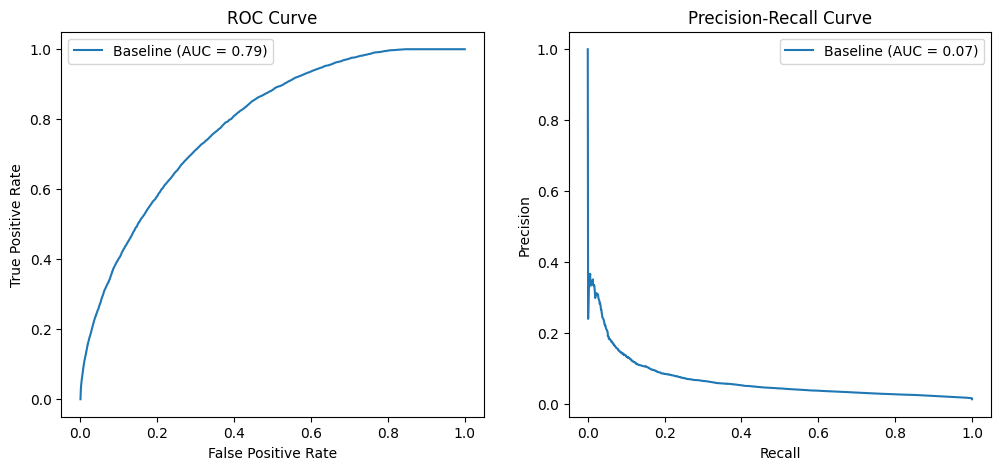

In [214]:
plot_roc_and_pr_curves("Baseline", y_pred=val_df["global_popularity"], y_test=val_df[label_col])
baseline_auc = auc_score(val_df[label_col], val_df["global_popularity"])

### Model training

In [215]:
def feature_label_split(df: pd.DataFrame, label_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    X = df.drop(columns=[label_col], axis=1)
    y = df[label_col]
    return X, y

X_train, y_train = feature_label_split(train_df, label_col)
X_val, y_val = feature_label_split(val_df, label_col)
X_test, y_test = feature_label_split(test_df, label_col)

In [216]:
train_cols = numerical_cols + binary_cols

### Linear Model

From the task of the previous module, we plot the best models for reference. We need to make sure our non-linear models (more complex models) improve on performance in order to justify the increase in model complexity.

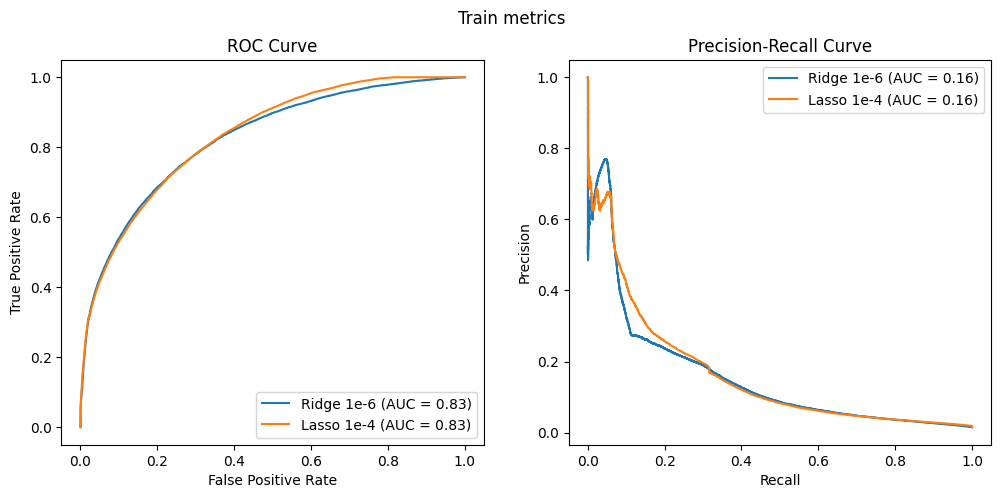

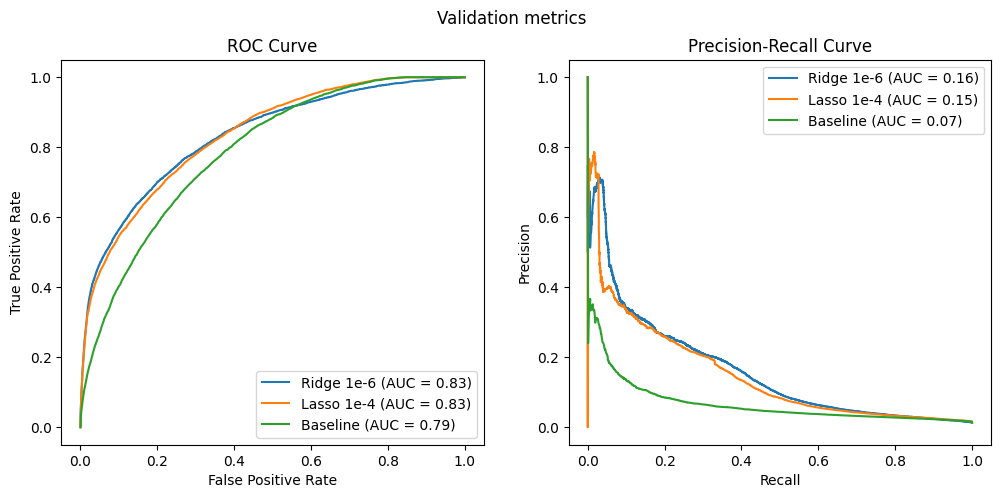

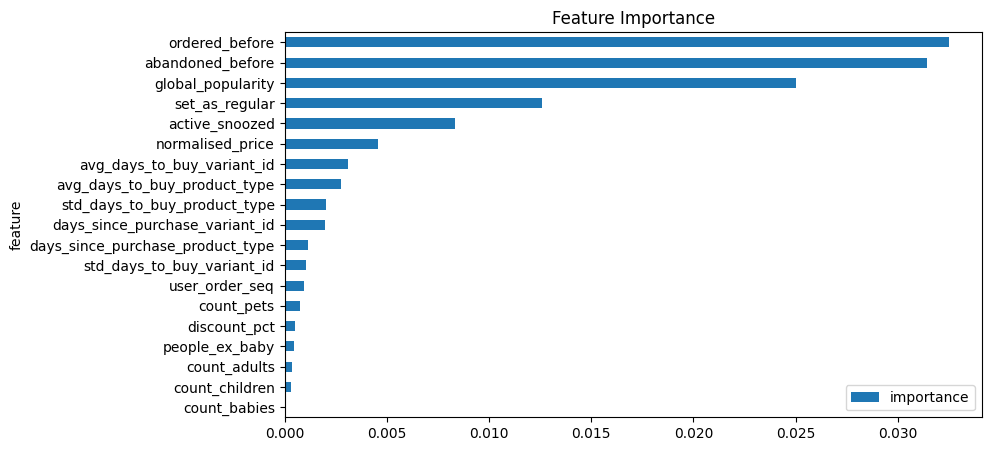

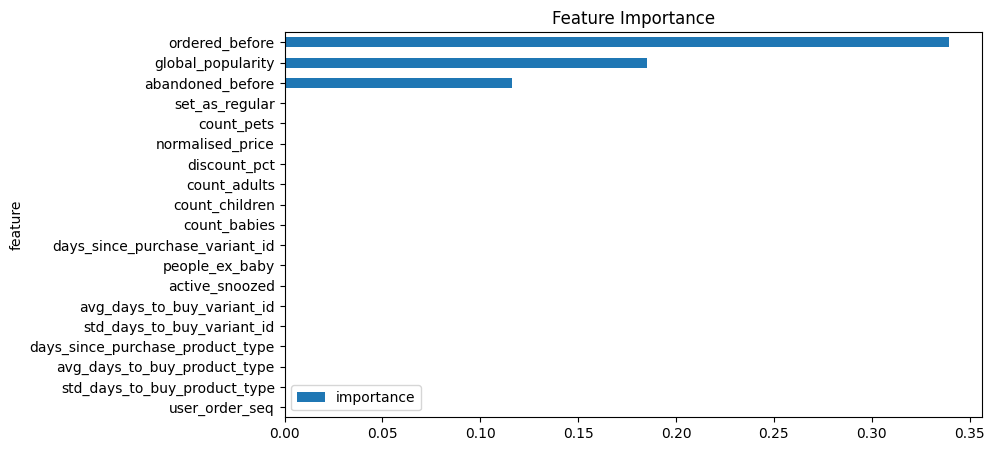

In [257]:
pr_auc_score_val = []
roc_auc_scores_val = []

fig1, ax1 = plt.subplots(1, 2, figsize=(12, 5))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(12, 5))
fig2.suptitle("Validation metrics")

lrs = [
    make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', C=1e-6)),
    make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', C=1e-4, solver='saga')),
]

names = ["Ridge 1e-6", "Lasso 1e-4"]
for name, lr in zip(names, lrs):
    lr.fit(X_train[train_cols], y_train)
    train_proba = lr.predict_proba(X_train[train_cols])[:, 1]
    plot_roc_and_pr_curves(name, y_pred=train_proba, y_test=y_train, figure=(fig1, ax1))
    
    val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
    plot_roc_and_pr_curves(name, y_pred=val_proba, y_test=y_val, figure=(fig2, ax2))
    auc_scores_val = auc_score(y_val, val_proba)
    roc_auc_scores_val.append(auc_scores_val[0])
    pr_auc_score_val.append(auc_scores_val[1])
    
    coeffs = lr.named_steps["logisticregression"].coef_[0]
    feat_importance = pd.DataFrame({"feature": train_cols, "importance": np.abs(coeffs)})
    feat_importance = feat_importance.sort_values('importance', ascending=True)
    feat_importance.plot(kind='barh', x='feature', y='importance', title="Feature Importance", figsize=(9, 5))
    
    
plot_roc_and_pr_curves("Baseline", y_pred=val_df["global_popularity"], y_test=val_df[label_col], figure=(fig2, ax2))

In [218]:
models = {
    "Model": ["Baseline", "Ridge 1e-6", "Lasso 1e-4"],
    "ROC AUC": [baseline_auc[0], roc_auc_scores_val[0], roc_auc_scores_val[1]],
    "PR AUC": [baseline_auc[1], pr_auc_score_val[0], pr_auc_score_val[1]]
    }
checkppoint_results = pd.DataFrame(models)
checkppoint_results

,Model,ROC AUC,PR AUC
0,Baseline,0.787093,0.066499
1,Ridge 1e-6,0.832559,0.160177
2,Lasso 1e-4,0.834434,0.148240


### Random Forest

In [224]:
roc_scores_train = []
roc_scores_val = []
pr_scores_train = []
pr_scores_val = []

n_estimtors = [1, 10, 50, 100]
max_depths = [2, 5, 7, 9]

hyperparameters = []

for d in max_depths:
    for n in n_estimtors:
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=0)
        rf.fit(X_train[train_cols], y_train)
        train_proba = rf.predict_proba(X_train[train_cols])[:, 1]   
        auc_scores_train = auc_score(y_train, train_proba)
        roc_scores_train.append(auc_scores_train[0])
        pr_scores_train.append(auc_scores_train[1])
        val_proba = rf.predict_proba(X_val[train_cols])[:, 1]
        auc_scores_val = auc_score(y_val, val_proba)
        roc_scores_val.append(auc_scores_val[0])
        pr_scores_val.append(auc_scores_val[1])
        
        hyperparameters.append((n, d))

results = pd.DataFrame({
    "Hyperparameters (estimators, depth)": hyperparameters,
    "ROC AUC Train": roc_scores_train,
    "PR AUC Train": pr_scores_train,
    "ROC AUC Val": roc_scores_val,
    "PR AUC Val": pr_scores_val})

results

,"Hyperparameters (estimators, depth)",ROC AUC Train,PR AUC Train,ROC AUC Val,PR AUC Val
0,"(1, 2)",0.536109,0.263299,0.594821,0.206286
1,"(10, 2)",0.786365,0.168654,0.788705,0.174788
2,"(50, 2)",0.809042,0.164210,0.810103,0.172845
3,"(100, 2)",0.808869,0.162937,0.811611,0.171217
4,"(1, 5)",0.649386,0.126528,0.697842,0.140273
5,"(10, 5)",0.829140,0.187983,0.829854,0.188227
6,"(50, 5)",0.832959,0.193983,0.834506,0.192882
7,"(100, 5)",0.833279,0.193266,0.834606,0.193213
8,"(1, 7)",0.804618,0.164473,0.806089,0.157061
9,"(10, 7)",0.833036,0.203179,0.834963,0.192430


In [225]:
results.sort_values("ROC AUC Val", ascending=False).head(3)

,"Hyperparameters (estimators, depth)",ROC AUC Train,PR AUC Train,ROC AUC Val,PR AUC Val
14,"(50, 9)",0.842514,0.228592,0.841271,0.198834
15,"(100, 9)",0.843131,0.228437,0.841020,0.200433
10,"(50, 7)",0.836934,0.208379,0.838462,0.197742


After trying different hyperparameters combinations we pick the one with `n_estimator=100` and `max_depth=9`. As seen from the table above (sorted by `ROC AUC Val`) those hyperparameters are't the best, however they yield the best PR AUC score, while only sacrificing 0.000251.

From the table with all the data we see that the improvement we get from 50 trees to 100 is very little, so trying with 150 is not worth it. However, the improvement leap in depth from 7 to 9 mayindicate that we can squeeze out a bit more performance by increasing the depth. Let's try with 100 and 150 trees for 9, 11 and 13 depths.

In [236]:
n_est = [100, 150]
depths = [9, 11, 13]

for n in n_est:
    for d in depths:
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=0)
        rf.fit(X_train[train_cols], y_train)
        train_proba = rf.predict_proba(X_train[train_cols])[:, 1]
        auc_scores_train = auc_score(y_train, train_proba)
        print(f"Estimators {n}, depth {d}. Train AUC: {auc_scores_train}")

        val_proba = rf.predict_proba(X_val[train_cols])[:, 1]
        auc_scores_val = auc_score(y_val, val_proba)
        print(f"Estimators {n}, depth {d}. Validation AUC: {auc_scores_val}")


Estimators 100, depth 9. Train AUC: (0.8431308542157552, 0.22843724976492064)
Estimators 100, depth 9. Validation AUC: (0.841019723103303, 0.2004329237782617)
Estimators 100, depth 11. Train AUC: (0.8510575200728553, 0.25673821728420076)
Estimators 100, depth 11. Validation AUC: (0.8443984795202771, 0.19989639803276882)
Estimators 100, depth 13. Train AUC: (0.8631656258184507, 0.29411427996351847)
Estimators 100, depth 13. Validation AUC: (0.8437744722414929, 0.19822915066240693)
Estimators 150, depth 9. Train AUC: (0.8432346790365738, 0.22881234769151487)
Estimators 150, depth 9. Validation AUC: (0.8410070722695171, 0.2005685047376905)
Estimators 150, depth 11. Train AUC: (0.851501087061485, 0.25704765292295273)
Estimators 150, depth 11. Validation AUC: (0.8444610396081079, 0.20021036219592903)
Estimators 150, depth 13. Train AUC: (0.8638383159973727, 0.2951477760867607)
Estimators 150, depth 13. Validation AUC: (0.8441732659744031, 0.19837703347620753)


The improvements we get by increasing the number of trees and depth are not very significative, thus not worth it the increase in execution time. We stick with `n_estimator=100` and `max_depth=9`.

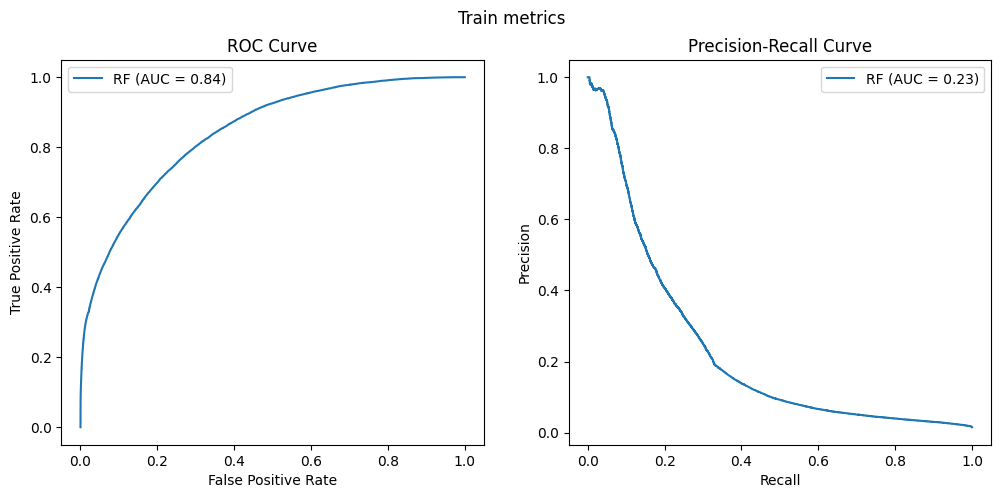

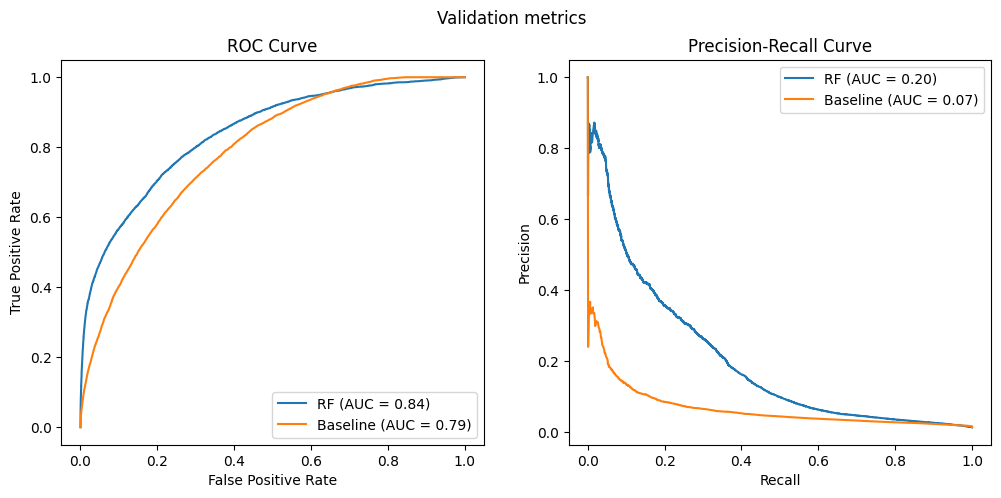

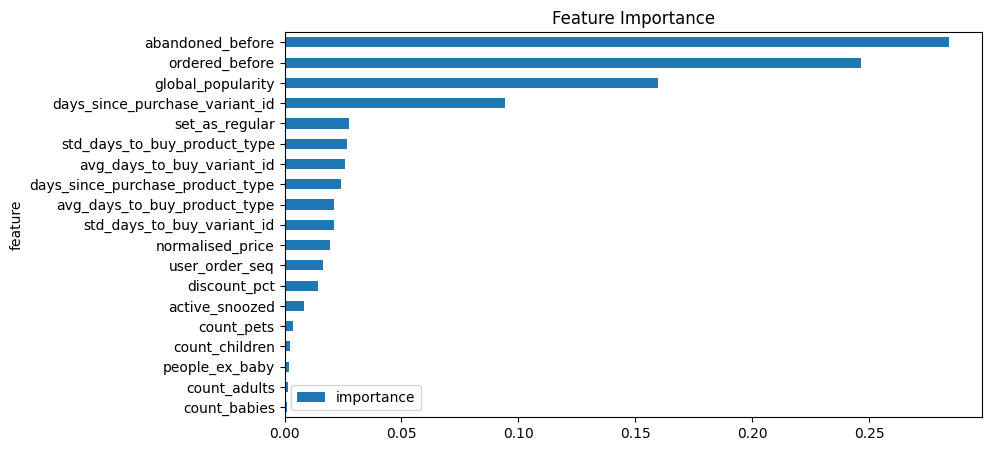

In [238]:
fig1, ax1 = plt.subplots(1, 2, figsize=(12, 5))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(12, 5))
fig2.suptitle("Validation metrics")

rf = RandomForestClassifier(n_estimators=100, max_depth=9, random_state=0)
rf.fit(X_train[train_cols], y_train)
train_proba = rf.predict_proba(X_train[train_cols])[:, 1]
plot_roc_and_pr_curves("RF", y_pred=train_proba, y_test=y_train, figure=(fig1, ax1))

val_proba = rf.predict_proba(X_val[train_cols])[:, 1]
plot_roc_and_pr_curves("RF", y_pred=val_proba, y_test=y_val, figure=(fig2, ax2))

coeffs = rf.feature_importances_
feat_importance = pd.DataFrame({"feature": train_cols, "importance": coeffs})
feat_importance = feat_importance.sort_values('importance', ascending=True)
feat_importance.plot(kind='barh', x='feature', y='importance', title="Feature Importance", figsize=(9, 5))
        
plot_roc_and_pr_curves("Baseline", y_pred=val_df["global_popularity"], y_test=val_df[label_col], figure=(fig2, ax2))

### Gradient Boosting

In [226]:
roc_scores_train = []
roc_scores_val = []
pr_scores_train = []
pr_scores_val = []

n_estimtors = [1, 10, 50, 100]
max_depths = [2, 5, 7, 9]
learnning_rate = [0.001, 0.01, 0.1]

hyper_estimators = []
hyper_depths = []
hyper_lr = []

for n in n_estimtors:
    for d in max_depths:
        for lr in learnning_rate:
            gbt = GradientBoostingClassifier(n_estimators=n, max_depth=d, learning_rate=lr)
            gbt.fit(X_train[train_cols], y_train)
            train_proba = gbt.predict_proba(X_train[train_cols])[:, 1]   
            auc_scores_train = auc_score(y_train, train_proba)
            roc_scores_train.append(auc_scores_train[0])
            pr_scores_train.append(auc_scores_train[1])
            val_proba = gbt.predict_proba(X_val[train_cols])[:, 1]
            auc_scores_val = auc_score(y_val, val_proba)
            roc_scores_val.append(auc_scores_val[0])
            pr_scores_val.append(auc_scores_val[1])
            
            hyper_estimators.append(n)
            hyper_depths.append(d)
            hyper_lr.append(lr)

results = pd.DataFrame({
    "Estimators": hyper_estimators,
    "Depth": hyper_depths,
    "learnning_rate": hyper_lr,
    "ROC AUC Train": roc_scores_train,
    "PR AUC Train": pr_scores_train,
    "ROC AUC Val": roc_scores_val,
    "PR AUC Val": pr_scores_val})

results

,Estimators,Depth,learnning_rate,ROC AUC Train,PR AUC Train,ROC AUC Val,PR AUC Val
0,1,2,0.001,0.646157,0.236856,0.654523,0.227075
1,1,2,0.010,0.646157,0.236856,0.654523,0.227075
2,1,2,0.100,0.646157,0.236856,0.654523,0.227075
3,1,5,0.001,0.817115,0.198580,0.818213,0.170498
4,1,5,0.010,0.817115,0.198580,0.818213,0.170498
5,1,5,0.100,0.817115,0.198580,0.818213,0.170498
6,1,7,0.001,0.836078,0.200076,0.835840,0.170370
7,1,7,0.010,0.836078,0.200076,0.835842,0.170508
8,1,7,0.100,0.836078,0.200076,0.835842,0.170508
9,1,9,0.001,0.840869,0.213039,0.834571,0.159354


In [231]:
results.sort_values("ROC AUC Val", ascending=False).head(9)

,Estimators,Depth,learnning_rate,ROC AUC Train,PR AUC Train,ROC AUC Val,PR AUC Val
29,50,5,0.10,0.845048,0.219997,0.846809,0.179914
41,100,5,0.10,0.847104,0.232739,0.846499,0.177450
32,50,7,0.10,0.850913,0.260989,0.846062,0.163007
38,100,2,0.10,0.840020,0.190637,0.844664,0.184307
20,10,7,0.10,0.843334,0.220594,0.844661,0.176982
46,100,9,0.01,0.846645,0.239594,0.844414,0.175713
43,100,7,0.01,0.841505,0.215009,0.844058,0.183511
44,100,7,0.10,0.853768,0.284612,0.843815,0.159704
23,10,9,0.10,0.850337,0.262643,0.843740,0.149277


From the previous table we see that the one with the best ROC AUC value isn't the best with the best PR AUC value. Therefore we choose the one with best PR AUC Val score (`n_estimators=100, max_depth=2, learning_rate=0.1`) that is only a bit worst than the first one in terms of ROC AUC score.

### Final conclusions

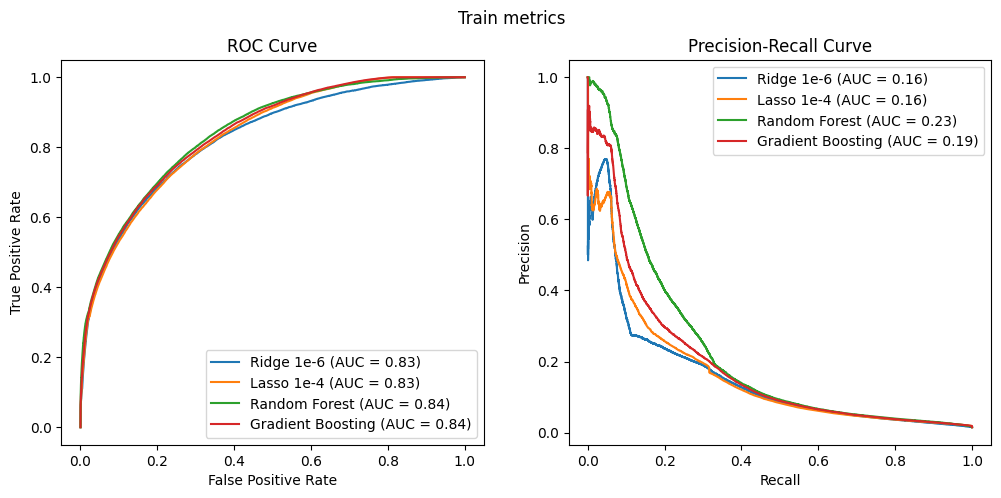

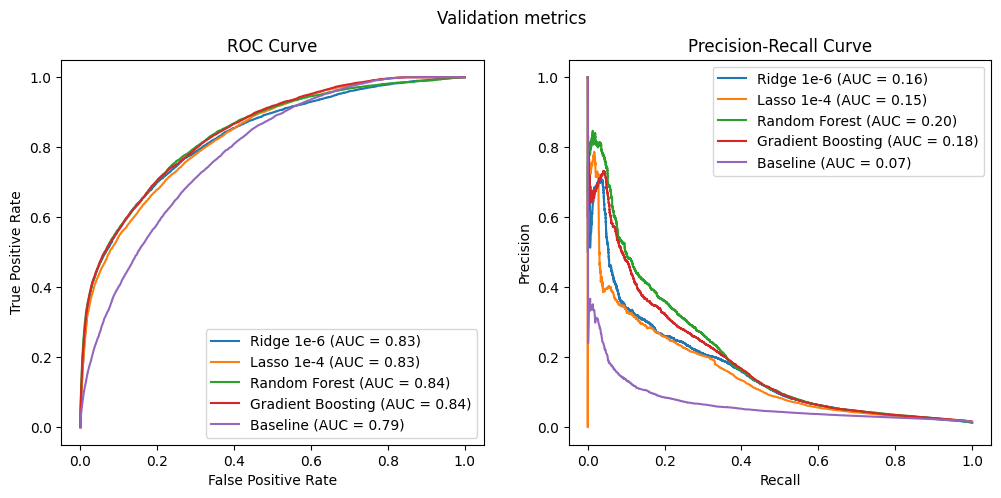

In [239]:
pr_auc_score_val = []
roc_auc_scores_val = []

fig1, ax1 = plt.subplots(1, 2, figsize=(12, 5))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(12, 5))
fig2.suptitle("Validation metrics")

lrs = [
    make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', C=1e-6)),
    make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', C=1e-4, solver='saga')),
    make_pipeline(RandomForestClassifier(n_estimators=100, max_depth=9)),
    make_pipeline(GradientBoostingClassifier(n_estimators=100, max_depth=2, learning_rate=0.1)),
]

names = ["Ridge 1e-6", "Lasso 1e-4", "Random Forest", "Gradient Boosting"]
for name, lr in zip(names, lrs):
    lr.fit(X_train[train_cols], y_train)
    train_proba = lr.predict_proba(X_train[train_cols])[:, 1]
    plot_roc_and_pr_curves(name, y_pred=train_proba, y_test=y_train, figure=(fig1, ax1))
    
    val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
    plot_roc_and_pr_curves(name, y_pred=val_proba, y_test=y_val, threshold_target=0.05, figure=(fig2, ax2))
    auc_scores_val = auc_score(y_val, val_proba)
    roc_auc_scores_val.append(auc_scores_val[0])
    pr_auc_score_val.append(auc_scores_val[1])
    
    
plot_roc_and_pr_curves("Baseline", y_pred=val_df["global_popularity"], y_test=val_df[label_col], figure=(fig2, ax2))

In [240]:
models = {
    "Model": ["Baseline"] + names,
    "ROC AUC": [baseline_auc[0]] + roc_auc_scores_val,
    "PR AUC": [baseline_auc[1]] + pr_auc_score_val
    }
final_results = pd.DataFrame(models)
final_results

,Model,ROC AUC,PR AUC
0,Baseline,0.787093,0.066499
1,Ridge 1e-6,0.832559,0.160177
2,Lasso 1e-4,0.834434,0.148240
3,Random Forest,0.840997,0.198718
4,Gradient Boosting,0.844664,0.184307


 Focusing on the AUC scores, we can see that RF is ahead of GBT, although not by much. If we check in the chart above, we can see that both ROC Curves are very similar. However, the thing changes when we focus on the PR Curve. With the RF ahead until a recall of ~0.4, from there, the two lines are similar.